1. Загрузка датасетов

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp "/content/drive/MyDrive/train_dataset_train.zip" "/content"
!unzip "/content/train_dataset_train.zip" -d "/content"

!cp "/content/drive/MyDrive/test_dataset_test.zip" "/content"
!unzip "/content/test_dataset_test.zip" -d "/content"

2. Установка необходимых библиотек

In [ ]:
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!gcc --version

In [ ]:
!pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113

In [ ]:
%cd /content/

!git clone https://github.com/facebookresearch/detectron2
%cd /content/detectron2
!python setup.py install
!pip install git+https://github.com/facebookresearch/fvcore.git

In [ ]:
!pip install omegaconf==2.1
!pip install iopath==0.1.7
!pip install termcolor
!pip install pycocotools==2.0.2

In [ ]:
!pip install fairscale

In [ ]:
!pip install yacs==0.1.8

In [7]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
import torch, torchvision
from tqdm import tqdm
import numpy as np
import pandas as pd
import gc, cv2, random, json, os, copy
import shutil

from IPython.display import Image
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from matplotlib import pyplot as plt

In [ ]:
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances, load_coco_json
from detectron2.data import detection_utils as utils
from detectron2.engine import DefaultTrainer
from detectron2.evaluation.evaluator import DatasetEvaluator
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import build_model
from detectron2.evaluation import COCOEvaluator
import detectron2.data.transforms as T
from detectron2.data import build_detection_train_loader, build_detection_test_loader
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode

3. Работа с данными

In [ ]:
classes = {
    "car": "0",
    "head": "1",
    "face": "2",
    "human": "3",
    "carplate": "4"
}

In [ ]:
# !rm -rf "/content/drive/MyDrive/Detectron2/data/train"
# !rm -rf "/content/drive/MyDrive/Detectron2/data/test"

In [8]:
DATA_PATH = "/content/drive/MyDrive/Detectron2/data/"

TRAIN_IMAGES_PATH = "/content/train/images/"
TRAIN_LABELS_PATH = "/content/train/labels/"

TEST_IMAGES_PATH = "/content/test/images/"


TRAIN_DATA_PATH = DATA_PATH + "train/"
TEST_DATA_PATH = DATA_PATH + "test/"

if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

if not os.path.exists(TRAIN_DATA_PATH):
    os.makedirs(TRAIN_DATA_PATH)

if not os.path.exists(TEST_DATA_PATH):
    os.makedirs(TEST_DATA_PATH)

In [ ]:
images_filenames = []
for i in os.walk(TRAIN_IMAGES_PATH):
  images_filenames = i[2]

labels_filenames = []
for i in os.walk(TRAIN_LABELS_PATH):
  labels_filenames = i[2]

images_filenames.sort()
labels_filenames.sort()

In [ ]:
print(len(images_filenames), len(labels_filenames))

2002 6004


In [ ]:
index = 0
for filename in images_filenames:
  file_name = filename[:-4]
  f_write = open(TRAIN_DATA_PATH + file_name + ".txt", "w")
  c = 0

  for i in range(index, len(labels_filenames)):
    if file_name in labels_filenames[i]:
      c += 1

      f_read = open(TRAIN_LABELS_PATH + labels_filenames[i]).readlines()
      if labels_filenames[i][:2]in ["0_", "1_", "2_", "3_", "4_"]:
        cls  = labels_filenames[i][25:-5]
      else:
        cls = labels_filenames[i][23:-5]

      for j in range(len(f_read)):
        x = classes[cls] + f_read[j][1:]
        f_write.write(x)
    else:
      break
  index += c
  shutil.copy2(TRAIN_IMAGES_PATH + filename, TRAIN_DATA_PATH + filename)
  f_write.close()

print("DATASET IS READY")

DATASET IS READY


In [ ]:
data = []

for i in os.walk(TRAIN_DATA_PATH):
  if len(i[2]) > 0:
    data = i[2]

data.sort()

train, test = data[:3980], data[3980:]
print("Train dataset: {}, Val dataset: {}".format(len(train), len(test)))

In [ ]:
for i in test:
  shutil.copy2(TRAIN_DATA_PATH + i, TEST_DATA_PATH + i)

In [ ]:
def yolo_to_coco(dir_path):
  dir = dir_path

  dataset = {}
  dataset["images"] = []
  dataset["annotations"] = []
  dataset["categories"] = [
      {"id": 0,
       "name": "car"},
      {"id": 1,
       "name": "head"},
      {"id": 2,
       "name": "face"},
      {"id": 3,
       "name": "human"},
      {"id": 4,
       "name": "carplate"}
  ]

  for i in os.walk(dir):
    if (len(i[2]) > 0):
      dir = i[2]
      break
  dir.sort()
  lbl_dir = dir[1::2]
  img_dir = dir[::2]

  ind = 0
  for index, img in enumerate(img_dir):
    if img[-4:] == ".txt":
      continue
    print(img)
    im = cv2.imread(dir_path + img)
    height, width, channels = im.shape
    dataset["images"].append({
        "id": index,
        "width": width,
        "height": height,
        "file_name": dir_path + img
    })
  
  for index, lbl in enumerate(lbl_dir):
    lbl = open(dir_path + lbl).readlines()
    h, w, c = cv2.imread(dir_path + img_dir[index]).shape

    for line in lbl:
      cls, x_center, y_center, width, height = map(float, line.rstrip("\n").split())
      w1 = w * width
      h1 = h * height
      x1 = x_center * w
      y1 = y_center * h
      dataset["annotations"].append({
          "id": ind,
          "category_id": int(cls),
          "iscrowd": 0,
          "image_id": index,
          "bbox": [x1 - w1 / 2, y1 - h1 / 2, w1, h1]
    })
      ind += 1
  return dataset


train_annotations = yolo_to_coco(TRAIN_DATA_PATH)
test_annotations = yolo_to_coco(TEST_DATA_PATH)

with open("/content/drive/MyDrive/Detectron2/data/train_annotations.json", "w") as outfile:
    json.dump(train_annotations, outfile)
with open("/content/drive/MyDrive/Detectron2/data/test_annotations.json", "w") as outfile:
    json.dump(test_annotations, outfile)

4. Регистрация датасетов

In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train", "test"]:
    DatasetCatalog.register("himichka_" + d, lambda d=d: load_coco_json(f"/content/drive/MyDrive/Detectron2/data/{d}_annotations.json",
                                                                        image_root= DATA_PATH + d,
                                                                        dataset_name="himichka_" + d,
                                                                        extra_annotation_keys=['bbox_mode']))

In [ ]:
dataset_dicts_train = DatasetCatalog.get("himichka_train")
train_metadata = MetadataCatalog.get("himichka_train") 

dataset_dicts_val = DatasetCatalog.get("himichka_test")
val_metadata = MetadataCatalog.get("himichka_test") 

In [ ]:
print('Размер обучающей выборки: {}'.format(len(dataset_dicts_train)))
print('Размер тестовой выборки: {}'.format(len(dataset_dicts_val)))

Размер обучающей выборки (Картинки): 2002
Размер тестовой выборки (Картинки): 12


In [ ]:
@interact
def show_images(file=range(len(dataset_dicts_val))):
    example = dataset_dicts_val[file]
    image = utils.read_image(example["file_name"], format="RGB")
    plt.figure(figsize=(3,3),dpi=250)
    visualizer = Visualizer(image[:, :, ::-1], metadata=val_metadata, scale=0.5, instance_mode=ColorMode.IMAGE_BW)
    vis = visualizer.draw_dataset_dict(example)
    plt.imshow(vis.get_image()[:, :,::-1])
    plt.show()

interactive(children=(Dropdown(description='file', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11), value=0), O…

5. Обучение и валидация модели

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file("/content/detectron2/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

cfg.DATASETS.TRAIN = ("himichka_train",)
cfg.DATASETS.TEST = ("himichka_test",)

cfg.TEST.EVAL_PERIOD = 1000

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3

cfg.DATALOADER.NUM_WORKERS = 4
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.01
cfg.SOLVER.GAMMA = 0.1
cfg.SOLVER.STEPS = (250,)
cfg.SOLVER.MAX_ITER = 15000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5
cfg.SOLVER.CHECKPOINT_PERIOD = cfg.TEST.EVAL_PERIOD
cfg.TEST.DETECTIONS_PER_IMAGE = 1000

cfg.OUTPUT_DIR = "/content/drive/MyDrive/Detectron2/output/aug_15_08_2022_10_09/"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# cfg.MODEL.DEVICE = "cpu"

trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[08/15 09:18:56 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[08/15 09:19:13 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[08/15 09:20:15 d2.utils.events]:  eta: 3:44:29  iter: 4019  total_loss: 0.5317  loss_cls: 0.1178  loss_box_reg: 0.2218  loss_rpn_cls: 0.01555  loss_rpn_loc: 0.1563  time: 1.2422  data_time: 1.6616  lr: 0.001  max_mem: 4852M
[08/15 09:20:44 d2.utils.events]:  eta: 3:52:48  iter: 4039  total_loss: 0.5359  loss_cls: 0.1308  loss_box_reg: 0.2296  loss_rpn_cls: 0.01287  loss_rpn_loc: 0.1625  time: 1.3344  data_time: 0.1260  lr: 0.001  max_mem: 4852M
[08/15 09:21:09 d2.utils.events]:  eta: 3:46:12  iter: 4059  total_loss: 0.5347  loss_cls: 0.1283  loss_box_reg: 0.2416  loss_rpn_cls: 0.02029  loss_rpn_loc: 0.1654  time: 1.3044  data_time: 0.0284  lr: 0.001  max_mem: 4852M
[08/15 09:21:35 d2.utils.events]:  eta: 3:48:29  iter: 4079  total_loss: 0.543  loss_cls: 0.1235  loss_box_reg: 0.2165  loss_rpn_cls: 0.01682  loss_rpn_loc: 0.1274  time: 1.2978  data_time: 0.0509  lr: 0.001  max_mem: 4852M
[08/15 09:22:00 d2.utils.events]:  eta: 3:48:46  iter: 4099  total_loss: 0.4683  loss_cls: 0.1047  lo

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[08/15 09:43:28 d2.utils.events]:  eta: 3:52:25  iter: 5019  total_loss: 0.4612  loss_cls: 0.1086  loss_box_reg: 0.2135  loss_rpn_cls: 0.0107  loss_rpn_loc: 0.1447  time: 1.3877  data_time: 0.0231  lr: 0.001  max_mem: 4959M
[08/15 09:43:56 d2.utils.events]:  eta: 3:52:08  iter: 5039  total_loss: 0.4564  loss_cls: 0.1121  loss_box_reg: 0.2034  loss_rpn_cls: 0.01034  loss_rpn_loc: 0.1143  time: 1.3880  data_time: 0.0264  lr: 0.001  max_mem: 4959M
[08/15 09:44:25 d2.utils.events]:  eta: 3:52:11  iter: 5059  total_loss: 0.449  loss_cls: 0.1017  loss_box_reg: 0.1989  loss_rpn_cls: 0.01228  loss_rpn_loc: 0.1203  time: 1.3891  data_time: 0.0334  lr: 0.001  max_mem: 4959M
[08/15 09:44:54 d2.utils.events]:  eta: 3:52:09  iter: 5079  total_loss: 0.504  loss_cls: 0.1185  loss_box_reg: 0.2404  loss_rpn_cls: 0.01323  loss_rpn_loc: 0.1442  time: 1.3902  data_time: 0.0268  lr: 0.001  max_mem: 4959M
[08/15 09:45:22 d2.utils.events]:  eta: 3:51:59  iter: 5099  total_loss: 0.4826  loss_cls: 0.1088  loss

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[08/15 10:07:10 d2.utils.events]:  eta: 3:33:52  iter: 6019  total_loss: 0.4384  loss_cls: 0.108  loss_box_reg: 0.1916  loss_rpn_cls: 0.01102  loss_rpn_loc: 0.1465  time: 1.4038  data_time: 0.0349  lr: 0.001  max_mem: 4959M
[08/15 10:07:38 d2.utils.events]:  eta: 3:33:23  iter: 6039  total_loss: 0.4693  loss_cls: 0.09298  loss_box_reg: 0.2118  loss_rpn_cls: 0.009845  loss_rpn_loc: 0.1269  time: 1.4036  data_time: 0.0279  lr: 0.001  max_mem: 4959M
[08/15 10:08:06 d2.utils.events]:  eta: 3:32:49  iter: 6059  total_loss: 0.466  loss_cls: 0.1023  loss_box_reg: 0.1962  loss_rpn_cls: 0.008286  loss_rpn_loc: 0.1387  time: 1.4037  data_time: 0.0291  lr: 0.001  max_mem: 4959M
[08/15 10:08:35 d2.utils.events]:  eta: 3:32:21  iter: 6079  total_loss: 0.4464  loss_cls: 0.1051  loss_box_reg: 0.2094  loss_rpn_cls: 0.0135  loss_rpn_loc: 0.1422  time: 1.4040  data_time: 0.0289  lr: 0.001  max_mem: 4959M
[08/15 10:09:03 d2.utils.events]:  eta: 3:31:59  iter: 6099  total_loss: 0.4996  loss_cls: 0.1107  l

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[08/15 10:30:47 d2.utils.events]:  eta: 3:09:11  iter: 7019  total_loss: 0.4174  loss_cls: 0.09245  loss_box_reg: 0.1911  loss_rpn_cls: 0.007191  loss_rpn_loc: 0.121  time: 1.4077  data_time: 0.0313  lr: 0.001  max_mem: 4959M
[08/15 10:31:16 d2.utils.events]:  eta: 3:08:54  iter: 7039  total_loss: 0.457  loss_cls: 0.1082  loss_box_reg: 0.2084  loss_rpn_cls: 0.01172  loss_rpn_loc: 0.1227  time: 1.4078  data_time: 0.0275  lr: 0.001  max_mem: 4959M
[08/15 10:31:45 d2.utils.events]:  eta: 3:08:25  iter: 7059  total_loss: 0.4279  loss_cls: 0.1003  loss_box_reg: 0.1825  loss_rpn_cls: 0.01012  loss_rpn_loc: 0.1235  time: 1.4081  data_time: 0.0333  lr: 0.001  max_mem: 4959M
[08/15 10:32:14 d2.utils.events]:  eta: 3:07:55  iter: 7079  total_loss: 0.4941  loss_cls: 0.1053  loss_box_reg: 0.2216  loss_rpn_cls: 0.01103  loss_rpn_loc: 0.1558  time: 1.4082  data_time: 0.0246  lr: 0.001  max_mem: 4959M
[08/15 10:32:41 d2.utils.events]:  eta: 3:07:18  iter: 7099  total_loss: 0.3992  loss_cls: 0.0953  l

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[08/15 10:54:34 d2.utils.events]:  eta: 2:46:53  iter: 8019  total_loss: 0.3926  loss_cls: 0.09409  loss_box_reg: 0.1802  loss_rpn_cls: 0.009726  loss_rpn_loc: 0.1203  time: 1.4118  data_time: 0.0296  lr: 0.001  max_mem: 4959M
[08/15 10:55:02 d2.utils.events]:  eta: 2:46:25  iter: 8039  total_loss: 0.4842  loss_cls: 0.1091  loss_box_reg: 0.2267  loss_rpn_cls: 0.009667  loss_rpn_loc: 0.1358  time: 1.4119  data_time: 0.0234  lr: 0.001  max_mem: 4959M
[08/15 10:55:31 d2.utils.events]:  eta: 2:45:52  iter: 8059  total_loss: 0.3919  loss_cls: 0.08895  loss_box_reg: 0.1767  loss_rpn_cls: 0.008854  loss_rpn_loc: 0.1232  time: 1.4119  data_time: 0.0284  lr: 0.001  max_mem: 4959M
[08/15 10:55:58 d2.utils.events]:  eta: 2:45:20  iter: 8079  total_loss: 0.3995  loss_cls: 0.08871  loss_box_reg: 0.1864  loss_rpn_cls: 0.007511  loss_rpn_loc: 0.1204  time: 1.4117  data_time: 0.0253  lr: 0.001  max_mem: 4959M
[08/15 10:56:27 d2.utils.events]:  eta: 2:44:52  iter: 8099  total_loss: 0.4291  loss_cls: 0.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[08/15 11:18:12 d2.utils.events]:  eta: 2:21:55  iter: 9019  total_loss: 0.5202  loss_cls: 0.1139  loss_box_reg: 0.2197  loss_rpn_cls: 0.01026  loss_rpn_loc: 0.142  time: 1.4127  data_time: 0.0230  lr: 0.001  max_mem: 4959M
[08/15 11:18:41 d2.utils.events]:  eta: 2:21:26  iter: 9039  total_loss: 0.4059  loss_cls: 0.08889  loss_box_reg: 0.18  loss_rpn_cls: 0.007133  loss_rpn_loc: 0.1189  time: 1.4128  data_time: 0.0295  lr: 0.001  max_mem: 4959M
[08/15 11:19:09 d2.utils.events]:  eta: 2:21:04  iter: 9059  total_loss: 0.4099  loss_cls: 0.09015  loss_box_reg: 0.1868  loss_rpn_cls: 0.008191  loss_rpn_loc: 0.1234  time: 1.4128  data_time: 0.0343  lr: 0.001  max_mem: 4959M
[08/15 11:19:38 d2.utils.events]:  eta: 2:20:38  iter: 9079  total_loss: 0.3813  loss_cls: 0.08663  loss_box_reg: 0.1772  loss_rpn_cls: 0.009165  loss_rpn_loc: 0.1046  time: 1.4128  data_time: 0.0287  lr: 0.001  max_mem: 4959M
[08/15 11:20:06 d2.utils.events]:  eta: 2:20:12  iter: 9099  total_loss: 0.4532  loss_cls: 0.1064

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[08/15 11:42:01 d2.utils.events]:  eta: 1:59:17  iter: 10019  total_loss: 0.4022  loss_cls: 0.08553  loss_box_reg: 0.1832  loss_rpn_cls: 0.009136  loss_rpn_loc: 0.1172  time: 1.4152  data_time: 0.0265  lr: 0.001  max_mem: 4959M
[08/15 11:42:30 d2.utils.events]:  eta: 1:58:48  iter: 10039  total_loss: 0.4054  loss_cls: 0.08448  loss_box_reg: 0.1738  loss_rpn_cls: 0.008235  loss_rpn_loc: 0.1196  time: 1.4153  data_time: 0.0276  lr: 0.001  max_mem: 4959M
[08/15 11:42:59 d2.utils.events]:  eta: 1:58:20  iter: 10059  total_loss: 0.3709  loss_cls: 0.08417  loss_box_reg: 0.1692  loss_rpn_cls: 0.008516  loss_rpn_loc: 0.1154  time: 1.4154  data_time: 0.0289  lr: 0.001  max_mem: 4959M
[08/15 11:43:28 d2.utils.events]:  eta: 1:57:50  iter: 10079  total_loss: 0.4055  loss_cls: 0.09056  loss_box_reg: 0.1888  loss_rpn_cls: 0.008713  loss_rpn_loc: 0.1172  time: 1.4154  data_time: 0.0247  lr: 0.001  max_mem: 4959M
[08/15 11:43:58 d2.utils.events]:  eta: 1:57:22  iter: 10099  total_loss: 0.4302  loss_c

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[08/15 12:06:04 d2.utils.events]:  eta: 1:36:02  iter: 11019  total_loss: 0.4413  loss_cls: 0.103  loss_box_reg: 0.1941  loss_rpn_cls: 0.009952  loss_rpn_loc: 0.1221  time: 1.4188  data_time: 0.0289  lr: 0.001  max_mem: 4959M
[08/15 12:06:33 d2.utils.events]:  eta: 1:35:33  iter: 11039  total_loss: 0.4375  loss_cls: 0.09573  loss_box_reg: 0.2027  loss_rpn_cls: 0.005752  loss_rpn_loc: 0.1152  time: 1.4189  data_time: 0.0287  lr: 0.001  max_mem: 4959M
[08/15 12:07:02 d2.utils.events]:  eta: 1:35:03  iter: 11059  total_loss: 0.4015  loss_cls: 0.09768  loss_box_reg: 0.204  loss_rpn_cls: 0.008228  loss_rpn_loc: 0.09292  time: 1.4189  data_time: 0.0269  lr: 0.001  max_mem: 4959M
[08/15 12:07:30 d2.utils.events]:  eta: 1:34:34  iter: 11079  total_loss: 0.4544  loss_cls: 0.1025  loss_box_reg: 0.1997  loss_rpn_cls: 0.008111  loss_rpn_loc: 0.1209  time: 1.4190  data_time: 0.0214  lr: 0.001  max_mem: 4959M
[08/15 12:07:59 d2.utils.events]:  eta: 1:34:06  iter: 11099  total_loss: 0.3867  loss_cls:

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[08/15 12:30:10 d2.utils.events]:  eta: 1:11:52  iter: 12019  total_loss: 0.4306  loss_cls: 0.09821  loss_box_reg: 0.2032  loss_rpn_cls: 0.007121  loss_rpn_loc: 0.1298  time: 1.4219  data_time: 0.0331  lr: 0.001  max_mem: 4959M
[08/15 12:30:39 d2.utils.events]:  eta: 1:11:28  iter: 12039  total_loss: 0.4328  loss_cls: 0.1057  loss_box_reg: 0.1867  loss_rpn_cls: 0.007571  loss_rpn_loc: 0.1199  time: 1.4219  data_time: 0.0258  lr: 0.001  max_mem: 4959M
[08/15 12:31:08 d2.utils.events]:  eta: 1:11:01  iter: 12059  total_loss: 0.3658  loss_cls: 0.08944  loss_box_reg: 0.1746  loss_rpn_cls: 0.007699  loss_rpn_loc: 0.1045  time: 1.4220  data_time: 0.0253  lr: 0.001  max_mem: 4959M
[08/15 12:31:37 d2.utils.events]:  eta: 1:10:34  iter: 12079  total_loss: 0.4113  loss_cls: 0.09011  loss_box_reg: 0.1958  loss_rpn_cls: 0.007814  loss_rpn_loc: 0.1061  time: 1.4221  data_time: 0.0252  lr: 0.001  max_mem: 4959M
[08/15 12:32:06 d2.utils.events]:  eta: 1:10:03  iter: 12099  total_loss: 0.4516  loss_cl

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[08/15 12:54:15 d2.utils.events]:  eta: 0:47:52  iter: 13019  total_loss: 0.3638  loss_cls: 0.08049  loss_box_reg: 0.1666  loss_rpn_cls: 0.007612  loss_rpn_loc: 0.09915  time: 1.4243  data_time: 0.0261  lr: 0.001  max_mem: 4959M
[08/15 12:54:44 d2.utils.events]:  eta: 0:47:23  iter: 13039  total_loss: 0.3282  loss_cls: 0.07516  loss_box_reg: 0.1606  loss_rpn_cls: 0.007195  loss_rpn_loc: 0.08934  time: 1.4243  data_time: 0.0271  lr: 0.001  max_mem: 4959M
[08/15 12:55:13 d2.utils.events]:  eta: 0:46:53  iter: 13059  total_loss: 0.4809  loss_cls: 0.1026  loss_box_reg: 0.2197  loss_rpn_cls: 0.01313  loss_rpn_loc: 0.1384  time: 1.4243  data_time: 0.0235  lr: 0.001  max_mem: 4959M
[08/15 12:55:40 d2.utils.events]:  eta: 0:46:23  iter: 13079  total_loss: 0.3672  loss_cls: 0.07952  loss_box_reg: 0.1653  loss_rpn_cls: 0.008827  loss_rpn_loc: 0.1122  time: 1.4243  data_time: 0.0266  lr: 0.001  max_mem: 4959M
[08/15 12:56:10 d2.utils.events]:  eta: 0:45:55  iter: 13099  total_loss: 0.4341  loss_c

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[08/15 13:18:15 d2.utils.events]:  eta: 0:23:43  iter: 14019  total_loss: 0.3837  loss_cls: 0.08536  loss_box_reg: 0.1752  loss_rpn_cls: 0.007318  loss_rpn_loc: 0.1052  time: 1.4257  data_time: 0.0270  lr: 0.001  max_mem: 4959M
[08/15 13:18:45 d2.utils.events]:  eta: 0:23:14  iter: 14039  total_loss: 0.3913  loss_cls: 0.08682  loss_box_reg: 0.1687  loss_rpn_cls: 0.005617  loss_rpn_loc: 0.09851  time: 1.4258  data_time: 0.0265  lr: 0.001  max_mem: 4959M
[08/15 13:19:13 d2.utils.events]:  eta: 0:22:44  iter: 14059  total_loss: 0.396  loss_cls: 0.08082  loss_box_reg: 0.1753  loss_rpn_cls: 0.00783  loss_rpn_loc: 0.1138  time: 1.4258  data_time: 0.0263  lr: 0.001  max_mem: 4959M
[08/15 13:19:41 d2.utils.events]:  eta: 0:22:15  iter: 14079  total_loss: 0.3429  loss_cls: 0.07691  loss_box_reg: 0.1574  loss_rpn_cls: 0.004498  loss_rpn_loc: 0.09429  time: 1.4258  data_time: 0.0268  lr: 0.001  max_mem: 4959M
[08/15 13:20:10 d2.utils.events]:  eta: 0:21:45  iter: 14099  total_loss: 0.3906  loss_c

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
import iopath
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

cfg = get_cfg()

cfg.merge_from_file("/content/detectron2/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/Detectron2/output/aug_15_08_2022_10_09/model_final.pth'

cfg.DATASETS.TRAIN = ("nyahimichka_train",)
cfg.DATASETS.TEST = ("nyahimichka_test",)

cfg.TEST.EVAL_PERIOD = 1000

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3

cfg.DATALOADER.NUM_WORKERS = 4
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.01
cfg.SOLVER.GAMMA = 0.1
cfg.SOLVER.STEPS = (250,)
cfg.SOLVER.MAX_ITER = 15000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5
cfg.SOLVER.CHECKPOINT_PERIOD = cfg.TEST.EVAL_PERIOD
cfg.TEST.DETECTIONS_PER_IMAGE = 1000

cfg.OUTPUT_DIR = "/content/drive/MyDrive/Detectron2/output/aug_15_08_2022_10_09/"

# cfg.MODEL.DEVICE = "cpu"

predictor = DefaultPredictor(cfg)

[08/15 13:42:30 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

6. Проверка, что модель правильно обучилась

{'instances': Instances(num_instances=14, image_height=1080, image_width=1920, fields=[pred_boxes: Boxes(tensor([[1357.7657,  701.8705, 1566.1556,  844.0699],
        [ 387.3043,  621.5397,  537.8940,  753.3755],
        [1324.7743,  635.1061, 1533.4498,  716.7928],
        [ 967.1906,  685.0197, 1120.3088,  827.1372],
        [1161.9360,  687.4852, 1372.9186,  838.1527],
        [ 467.3481,  581.7376,  695.3508,  667.7342],
        [ 571.4621,  643.2717,  732.5056,  778.6929],
        [ 766.4664,  663.5899,  912.4720,  797.7218],
        [1542.2515,  730.2016, 1723.7140,  840.7753],
        [1698.0161,  715.0780, 1908.8160,  842.2463],
        [ 909.3437,  637.5726,  953.5166,  778.0886],
        [ 455.3572,  527.1104,  510.1657,  574.4325],
        [ 924.6102,  640.6299,  946.3732,  662.6129],
        [1683.3109,  671.9505, 1887.8241,  737.4360]], device='cuda:0')), scores: tensor([0.9999, 0.9997, 0.9994, 0.9992, 0.9992, 0.9990, 0.9990, 0.9990, 0.9988,
        0.9981, 0.9968, 0.9928,

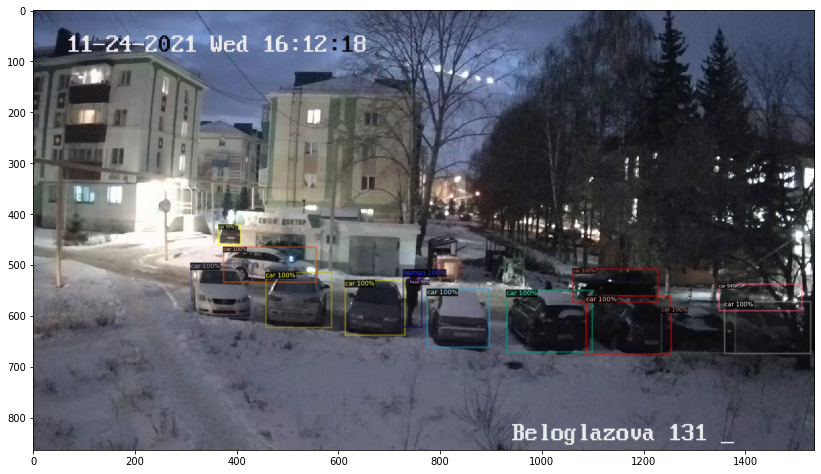

In [ ]:
from detectron2.utils.visualizer import ColorMode

imgs = ["/content/test/images/24-11-2021_01-12-19_PM.jpg"]
for d in imgs:    
    im = cv2.imread(d)
    outputs = predictor(im)
    print(outputs)
    v = Visualizer(im[:, :, ::-1],
                   metadata=train_metadata, 
                   scale=0.8
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

7. Предсказание результатов на тестовой выборке

In [ ]:
test_images = []

for i in os.walk("/content/test/images/"):
  test_images = i[2]

print(len(test_images))

x_mins = []
x_maxs = []
y_mins = []
y_maxs = []
file_names = []
classes = []
confs = []


for index, image in enumerate(test_images):
  im = cv2.imread("/content/test/images/" + image)
  height, width, channels = im.shape
  outputs = predictor(im)
  output = outputs["instances"].to("cpu")
  print(index)

  pred_boxes = output.pred_boxes
  pred_classes = output.pred_classes.numpy()
  confss = output.scores.numpy()
  for index, box in enumerate(pred_boxes):
    box = box.numpy()
    
    x1, y1, x2, y2 = box[0], box[1], box[2], box[3]
    cls = pred_classes[index]
    conf = confss[index]


    file_names.append(image)
    x_mins.append(x1/ width)
    x_maxs.append(x2 / width)
    y_maxs.append(y2 / height)
    y_mins.append(y1 / height)
    confs.append(conf)
    classes.append(cls)

solution = pd.DataFrame({
    "ImageID": file_names,
    "LabelName": classes,
    "Conf": confs,
    "XMin": x_mins,
    "XMax": x_maxs,
    "YMin": y_mins,
    "YMax": y_maxs
})
  

855
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27

8. Сохранение результатов

In [ ]:
predict = solution.to_csv("/content/detectron_prediction.csv", sep=";", index=None)